In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from autocorrelation.binning.funs import get_autocorrelation, get_autocorr_after_stimulus, fit_exponential_fixed_offset, estimate_surrogate
from autocorrelation.dgestimation import bias_variance_logtau
from data.celldata import CellData
from dfmp import DataFrameMP
import mypd
import myplt
from spiketrain.sptr import SpikeTrain
from stats import normal_pdf

root_folder = '/home/diego/storage/projects/auditory-cortex/data/'

In [2]:
folders = []
for hem_folder in ['ACx_data_1/ACxCalyx/', 'ACx_data_2/ACxCalyx/', 'ACx_data_3/ACxCalyx/', 
                   'ACx_data_1/ACxThelo/', 'ACx_data_2/ACxThelo/', 'ACx_data_3/ACxThelo/']:
    folders += [hem_folder + folder for folder in os.listdir(root_folder + hem_folder)]

df = pd.DataFrame(folders, columns=['cell'])
df['set'] = df.cell.str[9].astype(int)

df = df.reset_index(drop=True)
df['hemisphere'] = df['cell'].apply(lambda c: 'calyx' if 'Calyx' in c else 'thelo')

In [3]:
cell = df.iloc[8].cell

t0bin, tfbin, dtbin, biased = 100, 1640, 20, 1

cd = CellData(folder=root_folder + cell)
mask_spikes = get_autocorr_after_stimulus(cd, t0bin, tfbin)
t = np.arange(0, mask_spikes.shape[0], 1) * cd.dt
st = SpikeTrain(t, mask_spikes)

dt, n_spikes, n_trials, mean_n_spikes, sd_n_spikes, mean_isi, sd_isi, mean_autocor, sd_autocor, mse_mean, mse_offset = get_autocorrelation(cell, t0bin, tfbin, dtbin, biased, root_folder=root_folder)
lam = n_spikes / n_trials / (tfbin - t0bin)
offset_bin = (lam * dtbin)**2
t_autocor = np.arange(0, len(mean_autocor), 1) * dtbin

## Autocorrelation

1. Bin. $\Delta t=20ms$
2. Compute the **unbiased** raw autocorrelation. The biased autocorrelation has a dramatic effect on the offset of the decay causing the estimated offset with firing rate to deviate too much from the autocorrelation offset.

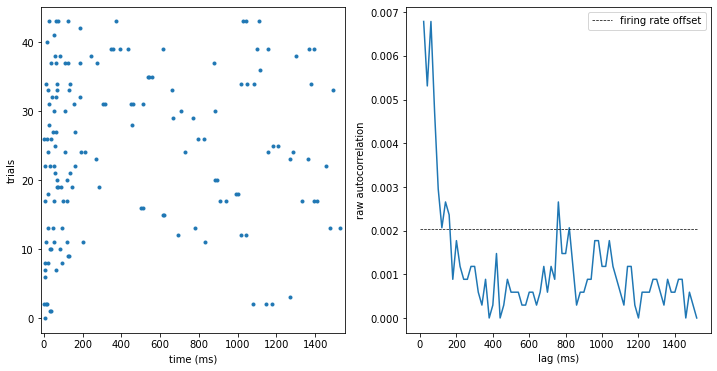

In [4]:
def plot_autocor(ax, t, autocor, offset):
    ax.plot(t[1:], autocor[1:])
    ax.plot(t, np.zeros(len(t)) + offset, 'k--', lw=0.7, label='firing rate offset')
    ax.legend()
    myplt.set_labels(ax, xlabel='lag (ms)', ylabel='raw autocorrelation')

fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
st.plot(ax=ax1, ms=3)
# ax2.plot(t_autocor[1:], mean_autocor[1:])
# ax2.plot(t_autocor, np.zeros(len(t_autocor)) + offset_bin, 'k--', lw=0.7, label='firing rate offset')
plot_autocor(ax2, t_autocor, mean_autocor, offset_bin)

# ax2.legend()
myplt.set_labels(ax1, xlabel='time (ms)', ylabel='trials')
# myplt.set_labels(ax2, xlabel='lag (ms)', ylabel='raw autocorrelation')

## Fit exponential decay

1. Define $B=(\lambda \Delta t)^2$ 

2. Fit $B + A \exp(-s / \tau)$. B is fixed. Try multitple initializations and get best $\hat{\tau}$ and $\hat{A}$.

In [5]:
seed = 1

tf_autocor = 1100
A0s = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
tau0s = [40, 640]
n_init = 40
bounds = ([0, 5e0], [0, np.inf])
offset0s = None#[5e-5, 1e-3, 5e-2]
fit_offset = False

t0_autocor, Abin_est, tau_est, offset_bin_est, mse_lsq = fit_exponential_fixed_offset(t0bin, tfbin, dtbin, n_spikes, n_trials, mean_autocor, tf_autocor, tau0s, A0s, offset0s=offset0s, 
                                                                                       n_init=n_init, bounds=bounds, fit_offset=fit_offset, uniform=True, seed=seed)

log_tau_est = np.log(tau_est)
offset_bin_est = offset_bin_est if fit_offset else offset_bin
autocor_est = offset_bin_est + Abin_est * np.exp(-t_autocor / tau_est)
argf_cor = int(tf_autocor / dtbin)

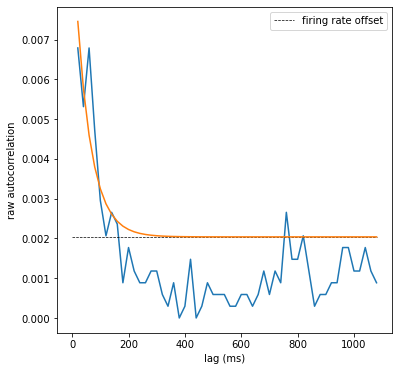

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_autocor(ax, t_autocor[:argf_cor], mean_autocor[:argf_cor], offset_bin)
ax.plot(t_autocor[1:argf_cor], autocor_est[1:argf_cor])

## Estimate $\tau$ bias and variance using surrogate data

1. Using DG model repeat N times
    1. Sample surrogate data using obtained firing rate and exponential autocorrelation with $\hat{\tau}$
    2. Fit exponential decay
    3. Obtain surrogate $\tau^{DG}$  


2. Assuming $\log \tau^{DG} \sim N(\mu, \sigma^2)$, obtain ML estimates for $\mu$ and $\sigma^2$

2. Compute bias and variance of. $Bias=E[\log \tau^{DG}] - \log \hat{\tau}$

**Optional:** replace $\log \hat{\tau}$ with the population average $E[\log \hat{\tau}]$

In [7]:
dtdg = 1
n = 100
shared_hem_tau, log_tau_hemisphere = False, 3
log_tau_true = log_tau_est if not(shared_hem_tau) else log_tau_hemisphere

df = pd.DataFrame([[0]], columns=['index'])

df = pd.concat([df] * n, ignore_index=True)
df['random_state'] = np.random.randint(1e8, size=len(df))

print('n_pars', len(df))

columns_out = ['fr_dg', 'mu_dg', 'var_dg', 'raw_autocorr', 'Abin_dg', 'tau_dg', 'offset_bin_dg', 'mse', 'max_error', 'cholesky']

dfd = DataFrameMP(df=df.iloc[:])
dfd = dfd.join(dfd.apply(estimate_surrogate, kwargs=dict(dtdg=dtdg, t0bin=t0bin, tfbin=tfbin, biased=biased, n_spikes=n_spikes, n_trials=n_trials, 
                                                         t0_autocorr=t0_autocor, tf_autocorr=tf_autocor, tau_true=tau_est, Abin=Abin_est, offset_bin=offset_bin_est, dtbin=dtbin, tau0s=tau0s, A0s=A0s, 
                                                         offset0s=offset0s, fit_offset=fit_offset, shared_hem_tau=shared_hem_tau, 
                                                                   n_init=n_init, bounds=bounds, uniform=True), 
                         processes=128, columns=columns_out))
dfd.df = mypd.list_columns_as_rows(dfd.df, drop_index=True)
dfd.df['logtau_dg'] = np.log(dfd.df['tau_dg'])

dfd.df = dfd.df[dfd.df.cholesky == 1]

bias_autocor, var_autocor, bias_logtau, var_logtau, mean_A_est = bias_variance_logtau(dfd.df, log_tau_true, autocor_true=mean_autocor)
logtau_dg_mean = dfd.df['logtau_dg'].mean()

n_pars 100


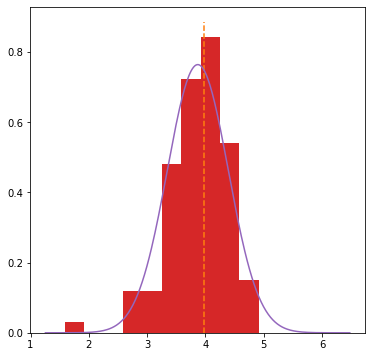

In [8]:
fig, ax1 = plt.subplots(figsize=(6, 6))
ax1.hist(dfd.df.logtau_dg, bins=10, color='C3', density=True)

x = np.arange(logtau_dg_mean - 5 * var_logtau**0.5, logtau_dg_mean + 5 * var_logtau**0.5, 0.02)
pdf = normal_pdf(x, logtau_dg_mean, np.sqrt(var_logtau))
y0, yf = ax1.get_ylim()
ax1.plot([log_tau_true, log_tau_true], [y0, yf], color='C1', linestyle='--')
ax1.plot(x, pdf, 'C4')

## Integrate evidence into a posterior

1. Unbiased observation from neuron $i$ is $\log \hat{\tau}^u_i = \log \hat{\tau}_i - Bias_i$

2. Assume $\log \hat{\tau}^u_i \sim N(\log \tau_{net}, \sigma^2_i)$

3. $P(\log \tau_{net} | \{\log \hat{\tau}^u_i\}) \propto P(\log \tau_{net}) \prod_i P(\log \hat{\tau}^u_i | \log \tau_{net}, \sigma^2_i)$. Using $P(\log \tau_{net})$ uniform.

![title](posteriors.png)